In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pickle
import os
import io
import plotly.graph_objects as go
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import plotly.io as pio


def prSpectrums(path="./PhotoReceptorData.pkl", plot=True):
    prSpectrums = np.load(path, allow_pickle=True)
    colors={"Scones": "blue", "Mcones": "green", "RedOpsin": "red", "Rods": "black", "Mela": "purple"}
    if plot:
        x_axis = prSpectrums["x_axis"]
        for pr in prSpectrums.keys():
            if pr == "x_axis":
                continue    
            plt.plot(x_axis, (prSpectrums[pr]), label=pr, color=colors[pr], linestyle="--", alpha = 0.5)
        plt.legend()
        plt.title("PhotoReceptors Spectrums")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Sensitivity")
    return prSpectrums


def ledSpectrums(path="./IlluminationData.pkl", plot=True):
    ledSpectrum = np.load(path, allow_pickle=True)
    colors = {"Blue": "blue", "Green": "green", "Red": "red", "White":"grey", "Violet": "purple", "Yellow": "orange"}

    if plot:
        x_axis = ledSpectrum["x_axis"]
        for led in ledSpectrum.keys():
            if led in ["x_axis","help"]:
                continue    
            plt.plot(x_axis, (np.clip(ledSpectrum[led]/max(ledSpectrum[led]), 0, None)), label=led, color=colors[led], alpha = 0.7)
        plt.legend()
        plt.title("LED Spectrums")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity")
    return ledSpectrum

def get_isomerisation_matrix(selected_opsins, selected_leds, opsinDATA_path="./PhotoReceptorData.pkl", ledDATA_path="./IlluminationDataMEA2.pkl", acDATA={"Scones": 0.2, "Mcones": 0.2, "RedOpsin": 0.002, "Rods": 0.5, "Mela": 0.2}, x_axis="x_axis"):
    
    """
    return the isomerisation matrix based on a selected set of opsins of interest and used LEDs
    
    Selected_opsins (resp. selected_leds) must call the keys of the dictionnary at opsinDATA_path (resp. ledDATA_path)
    lambda must be called "x_axis" or specified as a viariable to x_axis
    """

    h = 6.63 * 10**(-34)  # Planck constant in J.s
    c = 299792458         # Speed of light in m/s
    
    # Collecting areas for selected opsins
    Ac = np.array([acDATA[ac] for ac in selected_opsins])

    # Load opsin spectra data
    opsinsSpectrumsDATA = np.load(opsinDATA_path, allow_pickle=True)
    opsins = np.array([opsinsSpectrumsDATA[opsin_name] / opsinsSpectrumsDATA[opsin_name].max() for opsin_name in selected_opsins]) #Make sure it is normalized
    opsins[opsins < 0] = 0  # Set negative opsin values to 0
    
    # Load LED spectra data
    ledSpectrumDATA = np.load(ledDATA_path, allow_pickle=True)
    leds = np.array([ledSpectrumDATA[led] / ledSpectrumDATA[led].max() for led in selected_leds]) #Make sure it is normalized
    leds[leds < 0] = 0  # Set negative LED values to 0

    # Wavelengths (lambdas) for opsins and LEDs (they should be the same)
    lambdas_opsin = opsinsSpectrumsDATA[x_axis]
    lambdas_led = ledSpectrumDATA[x_axis]
    assert np.all(lambdas_opsin == lambdas_led), "Leds and Opsins spectrum don't match their lambdas"

    lambdas = lambdas_led
    dlambdas = np.diff(lambdas)
    dlambdas = np.hstack((np.mean(dlambdas[:3]), dlambdas))  # Ensure same length for lambdas and dlambdas

    leds = np.clip(leds / (np.sum(leds * dlambdas, axis=1)[:, None]), 0, None)   # Computing P(λ) / Integral(P(λ)dλ) and remove values under 0

    
    # Now we calculate the isomerisation without the loop.
    # Create a factor that doesn't depend on the wavelength (planck constant, speed of light, and collecting areas)
    normalization_factor = lambdas * dlambdas / (h * c) * 10**(-23)
    
    # Reshape for broadcasting and vectorized multiplication
    opsins_expanded = (opsins * Ac[:, None])  # Shape: (n_opsins, wavelengths)

    # Perform the element-wise multiplication across all wavelengths and then sum across the last axis (wavelengths)
    return np.sum(opsins_expanded[:, None, :] * leds[None, :, :] * normalization_factor, axis=2)



def interactive_Ptot_slider(
    selected_LEDs=None, 
    selected_opsins=None, 
    opsinDATA_path="./PhotoReceptorData.pkl", 
    ledDATA_path="./IlluminationDataMEA2.pkl",
    x_axis="x_axis",
    acDATA=None,
    max_vals=None,
    def_vals=None,
    FONT="Arial"
):
    
    """
    This function generates an interactive plot based on user input for various LED intensities and opsin data.

    Parameters:
    ----------
    selected_LEDs : list of str, optional
        A list of LEDs to be used for generating the plot. Each LED should correspond to an entry in the 'max_vals', 
        'def_vals', and 'colors' dictionaries. 
        Default is : ['Violet', 'Blue', 'Green', 'Yellow', 'Red'].

    selected_opsins : list of str, optional
        A list of opsins to consider in the calculations. These should be opsins included in the opsin spectrum file. 
        Default is : ["Scones", "Mela", "Rods", "Mcones", "RedOpsin"].

    opsinDATA_path : str, optional
        The file path to the opsin data (usually a pickle file). This file should contain necessary information 
        for opsin-specific parameters. 
        Default is : './PhotoReceptorData.pkl'.

    ledDATA_path : str, optional
        The file path to the LED data (usually a pickle file). This file should contain the illumination 
        properties for each LED. 
        Default : './IlluminationDataMEA2.pkl'.

    acDATA : dict, optional
        A dictionary with opsin names as keys and their associated alpha coefficients (numeric values) as values. 
        Default values are provided for common opsins: {'Scones': 0.2, 'Mcones': 0.2, 'RedOpsin': 0.002, 'Rods': 0.5, 'Mela': 0.2}.

    max_vals : dict, optional
        A dictionary with each LED as a key and the maximum intensity value for that LED as the value. 
        Default is : {'Violet': 5, 'Blue': 5, 'Green': 5, 'Yellow': 5, 'Red': 500}.

    def_vals : dict, optional
        A dictionary with each LED as a key and the default intensity value for that LED as the value. 
        Default is : {'Violet': 1, 'Blue': 1, 'Green': 1, 'Yellow': 1, 'Red': 0}.

    colors : dict, optional
        A dictionary that maps each LED to a color. This is used for visual differentiation in the plot. 
        Default is : {'Violet': 'violet', 'Blue': 'blue', 'Green': 'green', 'Yellow': 'orange', 'Red': 'red'}.

    Returns:
    -------
    None : 
        The function will open a Tkinter window with interactive sliders for adjusting the LED intensities 
        and display a plot showing the isomerization values based on the selected LEDs and opsins.

    Usage:
    ------
    To call this function, you can either pass in your custom data dictionaries or use the default values.

    Example 1: Using default dictionaries
    -------------------
    your_function_name()

    Example 2: Providing custom dictionaries
    -------------------
    custom_max_vals = {'Violet': 10, 'Blue': 8, 'Green': 6, 'Yellow': 5, 'Red': 400}
    custom_def_vals = {'Violet': 3, 'Blue': 2, 'Green': 2, 'Yellow': 2, 'Red': 100}
    custom_colors = {'Violet': 'purple', 'Blue': 'lightblue', 'Green': 'lime', 'Yellow': 'yellow', 'Red': 'darkred'}

    your_function_name(
        selected_LEDs=['Violet', 'Blue', 'Green'],
        max_vals=custom_max_vals,
        def_vals=custom_def_vals,
        colors=custom_colors
    )

    Notes:
    -----
    - The 'opsinDATA_path' and 'ledDATA_path' should point to valid pickle files containing the required data for opsins and LEDs.
    - These should be dictionnaries with keydefining the names for LEDs and Opsins to use in all other dictionnaries and values
      being numpy arrays of the spectrums
    - All spectrum must be measured at the same wavelength so that opsins and leds share the same x axis
    - You may want to provid your own name for the x_axis as here it is called by default x_axis = "x_axis"
    - Ensure that all the LEDs listed in the 'selected_LEDs' list are also present in the 'max_vals', 'def_vals', 
      and 'colors' dictionaries. Otherwise, an assertion error will be raised.
    - The 'opsinDATA_path' and 'ledDATA_path' should point to valid pickle files containing the required data for opsins and LEDs.
    """
    
    # Default values if no arguments are provided
    if selected_LEDs is None:
        selected_LEDs = ['Violet', 'Blue', 'Green', 'Yellow', 'Red']
    
    if selected_opsins is None:
        selected_opsins = ["Scones", "Mela", "Rods", "Mcones", "RedOpsin"]
    
    if acDATA is None:
        acDATA = {"Scones": 0.2, "Mcones": 0.2, "RedOpsin": 0.002, "Rods": 0.5, "Mela": 0.2}
    
    if max_vals is None:
        max_vals = {'Violet': 5, 'Blue': 5, 'Green': 5, 'Yellow': 5, 'Red': 500}
    
    if def_vals is None:
        def_vals = {'Violet': 1, 'Blue': 1, 'Green': 1, 'Yellow': 1, 'Red': 0}

    colors = {'Violet' : 'violet', 'Blue' : 'blue', 'Green' : 'green', 'Yellow' : 'orange', 'Red' : 'red'}

    assert all(led in max_vals and led in def_vals and led in colors for led in selected_LEDs), "Some LEDs in selected_LEDs are not detailed in max_vals, def_vals, or colors."
    assert all(opsin in acDATA for opsin in selected_opsins), "Some opsins are not defined in the acDATA dictionary."

    
    # Get isomerisation matrix
    isomerisation_matrix = get_isomerisation_matrix(
        selected_opsins, selected_LEDs, opsinDATA_path=opsinDATA_path, 
        ledDATA_path=ledDATA_path, acDATA=acDATA, x_axis=x_axis
    )

    # Function to update the plot based on user input
    def update_plot(Ptot_values):
        Ptot = np.array(Ptot_values)  # Convert the input values to a numpy array
        isomerisationMatrix = (isomerisation_matrix * Ptot.T)  # Compute the matrix
        
        fig = go.Figure()

        accumulated_heights = np.zeros(len(selected_opsins))  # Initialize accumulated heights to zero for each opsin
        cumulated_values = np.zeros(len(selected_opsins))  # Store cumulative values for annotations

        for i, led in enumerate(selected_LEDs):
            trace = go.Bar(
                x=selected_opsins,
                y=isomerisationMatrix[:, i],
                name=led,
                base=accumulated_heights,  # Stack the bars
                marker=dict(color=colors[led])  # Set the color for each LED
            )
            fig.add_trace(trace)
            accumulated_heights += isomerisationMatrix[:, i]  # Update the accumulated heights for the next LED
            cumulated_values += isomerisationMatrix[:, i]  # Update cumulative values

        fig.update_layout(
            barmode='stack',
            title="Isomerization of Opsins by LEDs",
            xaxis_title="Opsin",
            yaxis_title="Isomerization",
            legend_title="LEDs"
        )

        # Add cumulative values on top of each bar
        for i, value in enumerate(cumulated_values):
            fig.add_annotation(
                x=selected_opsins[i],
                y=value,
                text=f"{round(value)}",
                showarrow=True,
                arrowhead=2,
                ax=0,
                ay=-20,
                font=dict(size=10, color="black"),
                arrowcolor="black"
            )

        # Render the Plotly figure to a static image (PNG format)
        img_bytes = pio.to_image(fig, format='png')
        img = Image.open(io.BytesIO(img_bytes))
        img_tk = ImageTk.PhotoImage(img)

        # Update the image label with the new plot
        image_label.config(image=img_tk)
        image_label.image = img_tk  # Keep a reference to the image

    # Bind the slider value change to update the corresponding value label
    def update_value_label(slider, value_entry, i):
        value = Ptot_values[i].get()
        value_entry.delete(0, tk.END)
        value_entry.insert(0, f"{value:.3f}")
        update_plot([Ptot_values[j].get() for j in range(len(selected_LEDs))])

    def on_entry_change(value_entry, i):
        try:
            new_value = float(value_entry.get())
            if 0 <= new_value:
                Ptot_values[i].set(new_value)
                update_plot([Ptot_values[j].get() for j in range(len(selected_LEDs))])
            else:
                value_entry.delete(0, tk.END)
                value_entry.insert(0, f"{Ptot_values[i].get():.3f}")
        except ValueError:
            pass  # Ignore invalid input

    def reset_Ptot_values(event=None):
        for i, led in enumerate(selected_LEDs):
            val = def_vals[led]
            Ptot_values[i].set(val)
            value_entries[led].delete(0, tk.END)
            value_entries[led].insert(0, f"{val:.3f}")
        
        update_plot([Ptot_values[i].get() for i in range(len(selected_LEDs))])

        
    def print_values_on_close():
        # Print LED power values
        print("LED Power Values (µW/cm²):")
        for i, led in enumerate(selected_LEDs):
            print(f"{led}: {Ptot_values[i].get():.3f}")

        # Print Opsin Isomerization
        print("\nOpsin Isomerization Values:")
        Ptot = np.array([Ptot_values[i].get() for i in range(len(selected_LEDs))])
        isomerisationMatrix = (isomerisation_matrix@Ptot[:,None])  # Compute the matrix

        for i, opsin in enumerate(selected_opsins):
            print(f"{opsin}: {(isomerisationMatrix[i].astype(int))}")

        # Close the application
        root.destroy()
    
    
    # GUI setup using Tkinter
    root = tk.Tk()
    root.minsize(600, 650)
    root.maxsize(1000, 800)
    root.title("Interactive Ptot Slider")
    root.resizable(True, True)

    # Create sliders for each LED in Ptot (each slider goes from 0 to max value for each LED)
    Ptot_values = [tk.DoubleVar(value=1.0) for _ in selected_LEDs]
    value_entries = {}  # List to store Entry widgets

    for i, led in enumerate(selected_LEDs):
        slider = ttk.Scale(root, from_=0, to=max_vals[led], orient="horizontal", variable=Ptot_values[i], length=300)
        slider.set(def_vals[led])
        slider.grid(row=i, column=1, padx=10, pady=10, sticky="nsew")
        
        label = ttk.Label(root, text=led, anchor="e", font=FONT + ' 13 bold')
        label.grid(row=i, column=0, padx=10, pady=10, sticky="nsew")
        
        frame = ttk.Frame(root)
        frame.grid(row=i, column=2, padx=5, pady=0, sticky="nsew")

        value_entry = ttk.Entry(frame, font=FONT + ' 10', width=8)
        value_entry.insert(0, f"{def_vals[led]:.3f}")
        value_entry.grid(row=0, column=0, padx=(0, 5), pady=10, sticky="nsew")

        unit_label = ttk.Label(frame, text="µW/cm²", font=FONT + ' 10')
        unit_label.grid(row=0, column=1, padx=(0, 0), pady=10, sticky="nsew")
        
        value_entries[led] = value_entry
        
        slider.bind("<Motion>", lambda event, slider=slider, value_entry=value_entry, i=i: update_value_label(slider, value_entry, i))
        value_entry.bind("<FocusOut>", lambda event, value_entry=value_entry, i=i: on_entry_change(value_entry, i))
        value_entry.bind("<Return>", lambda event, value_entry=value_entry, i=i: on_entry_change(value_entry, i))

    root.bind("<space>", reset_Ptot_values)
    root.protocol("WM_DELETE_WINDOW", print_values_on_close)  # Bind the close event

    image_label = ttk.Label(root, anchor='center')
    image_label.grid(row=len(selected_LEDs) + 1, columnspan=3, pady=20, sticky="nsew")

    # Configure grid resizing
    for i in range(len(selected_LEDs)):
        root.grid_rowconfigure(i, weight=1, minsize=33)
    root.grid_rowconfigure(len(selected_LEDs) + 1, weight=1, minsize=10)
    for i in range(3):
        root.grid_columnconfigure(i, weight=1, minsize=100)

    # Initialize with an empty plot
    update_plot([Ptot_values[i].get() for i in range(len(selected_LEDs))])

    # Run the GUI
    root.mainloop()


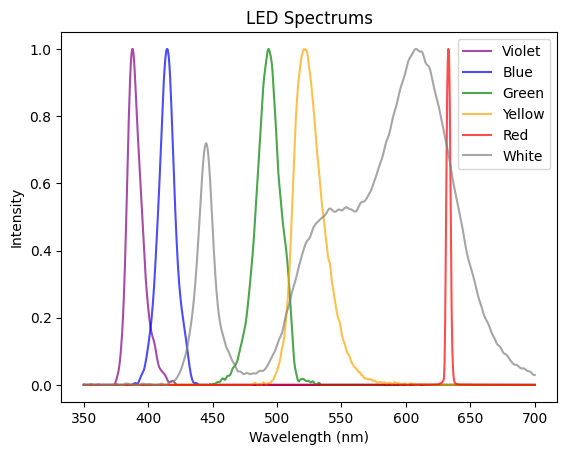

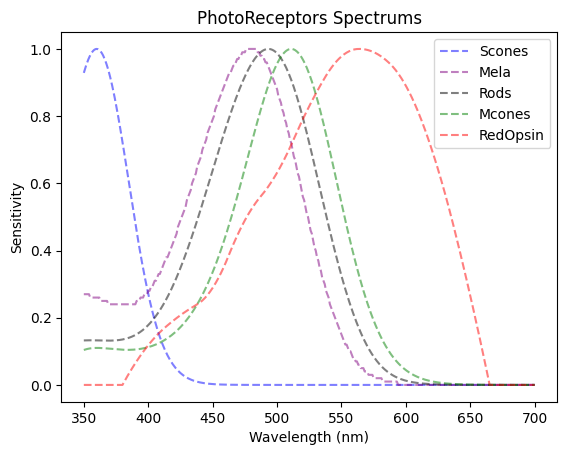

In [2]:
opsinDATA_path="./PhotoReceptorData.pkl"
ledDATA_path="./IlluminationDataMEA2.pkl"

ledSpectrum = ledSpectrums(path = ledDATA_path)
plt.figure()
prSpectrum = prSpectrums(path = opsinDATA_path)


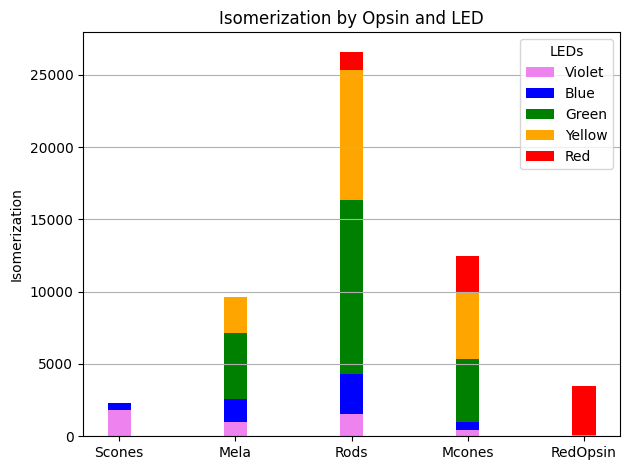

In [3]:
Ptot = np.array([1, 1, 1, 1, 100])

selected_LEDs = ['Violet', 'Blue', 'Green', 'Yellow', 'Red']
selected_opsins = ["Scones", "Mela", "Rods", "Mcones", "RedOpsin"]

isomerisation_matrix = get_isomerisation_matrix(selected_opsins, selected_LEDs) 

# Compute the matrix
isomerisationMatrix = (isomerisation_matrix * Ptot.T)

# Number of groups and categories
num_groups, num_categories = isomerisationMatrix.shape
colors = ['Violet', 'Blue', 'Green', 'orange', 'Red']

# Create figure and axis for the plot
fig, ax = plt.subplots()

# Set the positions and width for the bars
positions = np.arange(num_groups)
width = 0.2  # Width of each bar

# Plot bars for each category, stacking them
accumulated_heights = np.zeros(num_groups)  # Initialize accumulated heights to zero for each group

for i in range(num_categories):
    ax.bar(positions, isomerisationMatrix[:, i], width, bottom=accumulated_heights, color=colors[i], label=selected_LEDs[i])
    accumulated_heights += isomerisationMatrix[:, i]  # Update the accumulated heights for the next iteration

# Add labels, title, and other customizations
ax.set_ylabel('Isomerization')
ax.set_title('Isomerization by Opsin and LED')
ax.set_xticks(positions)
ax.set_xticklabels(selected_opsins)
ax.legend(title="LEDs")
ax.grid(True, axis='y')

# Show the plot
plt.tight_layout()  # To ensure labels are not cut off
plt.show()


In [4]:
def interactive_Ptot_slider(
    selected_LEDs=None, 
    selected_opsins=None, 
    opsinDATA_path="./PhotoReceptorData.pkl", 
    ledDATA_path="./IlluminationDataMEA2.pkl",
    x_axis="x_axis",
    acDATA=None,
    max_vals=None,
    def_vals=None,
    FONT="Arial"
):
    
    """
    This function generates an interactive plot based on user input for various LED intensities and opsin data.

    Parameters:
    ----------
    selected_LEDs : list of str, optional
        A list of LEDs to be used for generating the plot. Each LED should correspond to an entry in the 'max_vals', 
        'def_vals', and 'colors' dictionaries. 
        Default is : ['Violet', 'Blue', 'Green', 'Yellow', 'Red'].

    selected_opsins : list of str, optional
        A list of opsins to consider in the calculations. These should be opsins included in the opsin spectrum file. 
        Default is : ["Scones", "Mela", "Rods", "Mcones", "RedOpsin"].

    opsinDATA_path : str, optional
        The file path to the opsin data (usually a pickle file). This file should contain necessary information 
        for opsin-specific parameters. 
        Default is : './PhotoReceptorData.pkl'.

    ledDATA_path : str, optional
        The file path to the LED data (usually a pickle file). This file should contain the illumination 
        properties for each LED. 
        Default : './IlluminationDataMEA2.pkl'.

    acDATA : dict, optional
        A dictionary with opsin names as keys and their associated alpha coefficients (numeric values) as values. 
        Default values are provided for common opsins: {'Scones': 0.2, 'Mcones': 0.2, 'RedOpsin': 0.002, 'Rods': 0.5, 'Mela': 0.2}.

    max_vals : dict, optional
        A dictionary with each LED as a key and the maximum intensity value for that LED as the value. 
        Default is : {'Violet': 5, 'Blue': 5, 'Green': 5, 'Yellow': 5, 'Red': 500}.

    def_vals : dict, optional
        A dictionary with each LED as a key and the default intensity value for that LED as the value. 
        Default is : {'Violet': 1, 'Blue': 1, 'Green': 1, 'Yellow': 1, 'Red': 0}.

    colors : dict, optional
        A dictionary that maps each LED to a color. This is used for visual differentiation in the plot. 
        Default is : {'Violet': 'violet', 'Blue': 'blue', 'Green': 'green', 'Yellow': 'orange', 'Red': 'red'}.

    Returns:
    -------
    None : 
        The function will open a Tkinter window with interactive sliders for adjusting the LED intensities 
        and display a plot showing the isomerization values based on the selected LEDs and opsins.

    Usage:
    ------
    To call this function, you can either pass in your custom data dictionaries or use the default values.

    Example 1: Using default dictionaries
    -------------------
    your_function_name()

    Example 2: Providing custom dictionaries
    -------------------
    custom_max_vals = {'Violet': 10, 'Blue': 8, 'Green': 6, 'Yellow': 5, 'Red': 400}
    custom_def_vals = {'Violet': 3, 'Blue': 2, 'Green': 2, 'Yellow': 2, 'Red': 100}
    custom_colors = {'Violet': 'purple', 'Blue': 'lightblue', 'Green': 'lime', 'Yellow': 'yellow', 'Red': 'darkred'}

    your_function_name(
        selected_LEDs=['Violet', 'Blue', 'Green'],
        max_vals=custom_max_vals,
        def_vals=custom_def_vals,
        colors=custom_colors
    )

    Notes:
    -----
    - The 'opsinDATA_path' and 'ledDATA_path' should point to valid pickle files containing the required data for opsins and LEDs.
    - These should be dictionnaries with keydefining the names for LEDs and Opsins to use in all other dictionnaries and values
      being numpy arrays of the spectrums
    - All spectrum must be measured at the same wavelength so that opsins and leds share the same x axis
    - You may want to provid your own name for the x_axis as here it is called by default x_axis = "x_axis"
    - Ensure that all the LEDs listed in the 'selected_LEDs' list are also present in the 'max_vals', 'def_vals', 
      and 'colors' dictionaries. Otherwise, an assertion error will be raised.
    - The 'opsinDATA_path' and 'ledDATA_path' should point to valid pickle files containing the required data for opsins and LEDs.
    """
    
    # Default values if no arguments are provided
    if selected_LEDs is None:
        selected_LEDs = ['Violet', 'Blue', 'Green', 'Yellow', 'Red']
    
    if selected_opsins is None:
        selected_opsins = ["Scones", "Mela", "Rods", "Mcones", "RedOpsin"]
    
    if acDATA is None:
        acDATA = {"Scones": 0.2, "Mcones": 0.2, "RedOpsin": 0.002, "Rods": 0.5, "Mela": 0.2}
    
    if max_vals is None:
        max_vals = {'Violet': 5, 'Blue': 5, 'Green': 5, 'Yellow': 5, 'Red': 500}
    
    if def_vals is None:
        def_vals = {'Violet': 1, 'Blue': 1, 'Green': 1, 'Yellow': 1, 'Red': 0}

    colors = {'Violet' : 'violet', 'Blue' : 'blue', 'Green' : 'green', 'Yellow' : 'orange', 'Red' : 'red'}

    assert all(led in max_vals and led in def_vals and led in colors for led in selected_LEDs), "Some LEDs in selected_LEDs are not detailed in max_vals, def_vals, or colors."
    assert all(opsin in acDATA for opsin in selected_opsins), "Some opsins are not defined in the acDATA dictionary."

    
    # Get isomerisation matrix
    isomerisation_matrix = get_isomerisation_matrix(
        selected_opsins, selected_LEDs, opsinDATA_path=opsinDATA_path, 
        ledDATA_path=ledDATA_path, acDATA=acDATA, x_axis=x_axis
    )

    # Function to update the plot based on user input
    def update_plot(Ptot_values):
        Ptot = np.array(Ptot_values)  # Convert the input values to a numpy array
        isomerisationMatrix = (isomerisation_matrix * Ptot.T)  # Compute the matrix
        
        fig = go.Figure()

        accumulated_heights = np.zeros(len(selected_opsins))  # Initialize accumulated heights to zero for each opsin
        cumulated_values = np.zeros(len(selected_opsins))  # Store cumulative values for annotations

        for i, led in enumerate(selected_LEDs):
            trace = go.Bar(
                x=selected_opsins,
                y=isomerisationMatrix[:, i],
                name=led,
                base=accumulated_heights,  # Stack the bars
                marker=dict(color=colors[led])  # Set the color for each LED
            )
            fig.add_trace(trace)
            accumulated_heights += isomerisationMatrix[:, i]  # Update the accumulated heights for the next LED
            cumulated_values += isomerisationMatrix[:, i]  # Update cumulative values

        fig.update_layout(
            barmode='stack',
            title="Isomerization of Opsins by LEDs",
            xaxis_title="Opsin",
            yaxis_title="Isomerization",
            legend_title="LEDs"
        )

        # Add cumulative values on top of each bar
        for i, value in enumerate(cumulated_values):
            fig.add_annotation(
                x=selected_opsins[i],
                y=value,
                text=f"{round(value)}",
                showarrow=True,
                arrowhead=2,
                ax=0,
                ay=-20,
                font=dict(size=10, color="black"),
                arrowcolor="black"
            )

        # Render the Plotly figure to a static image (PNG format)
        img_bytes = pio.to_image(fig, format='png')
        img = Image.open(io.BytesIO(img_bytes))
        img_tk = ImageTk.PhotoImage(img)

        # Update the image label with the new plot
        image_label.config(image=img_tk)
        image_label.image = img_tk  # Keep a reference to the image

    # Bind the slider value change to update the corresponding value label
    def update_value_label(slider, value_entry, i):
        value = Ptot_values[i].get()
        value_entry.delete(0, tk.END)
        value_entry.insert(0, f"{value:.3f}")
        update_plot([Ptot_values[j].get() for j in range(len(selected_LEDs))])

    def on_entry_change(value_entry, i):
        try:
            new_value = float(value_entry.get())
            if 0 <= new_value:
                Ptot_values[i].set(new_value)
                update_plot([Ptot_values[j].get() for j in range(len(selected_LEDs))])
            else:
                value_entry.delete(0, tk.END)
                value_entry.insert(0, f"{Ptot_values[i].get():.3f}")
        except ValueError:
            pass  # Ignore invalid input

    def reset_Ptot_values(event=None):
        for i, led in enumerate(selected_LEDs):
            val = def_vals[led]
            Ptot_values[i].set(val)
            value_entries[led].delete(0, tk.END)
            value_entries[led].insert(0, f"{val:.3f}")
        
        update_plot([Ptot_values[i].get() for i in range(len(selected_LEDs))])

        
    def print_values_on_close():
        # Print LED power values
        print("LED Power Values (µW/cm²):")
        for i, led in enumerate(selected_LEDs):
            print(f"{led}: {Ptot_values[i].get():.3f}")

        # Print Opsin Isomerization
        print("\nOpsin Isomerization Values:")
        Ptot = np.array([Ptot_values[i].get() for i in range(len(selected_LEDs))])
        isomerisationMatrix = (isomerisation_matrix@Ptot[:,None])  # Compute the matrix

        for i, opsin in enumerate(selected_opsins):
            print(f"{opsin}: {(isomerisationMatrix[i].astype(int))}")

        # Close the application
        root.destroy()
    
    
    # GUI setup using Tkinter
    root = tk.Tk()
    root.minsize(600, 650)
    root.maxsize(1000, 800)
    root.title("Interactive Ptot Slider")
    root.resizable(True, True)

    # Create sliders for each LED in Ptot (each slider goes from 0 to max value for each LED)
    Ptot_values = [tk.DoubleVar(value=1.0) for _ in selected_LEDs]
    value_entries = {}  # List to store Entry widgets

    for i, led in enumerate(selected_LEDs):
        slider = ttk.Scale(root, from_=0, to=max_vals[led], orient="horizontal", variable=Ptot_values[i], length=300)
        slider.set(def_vals[led])
        slider.grid(row=i, column=1, padx=10, pady=10, sticky="nsew")
        
        label = ttk.Label(root, text=led, anchor="e", font=FONT + ' 13 bold')
        label.grid(row=i, column=0, padx=10, pady=10, sticky="nsew")
        
        frame = ttk.Frame(root)
        frame.grid(row=i, column=2, padx=5, pady=0, sticky="nsew")

        value_entry = ttk.Entry(frame, font=FONT + ' 10', width=8)
        value_entry.insert(0, f"{def_vals[led]:.3f}")
        value_entry.grid(row=0, column=0, padx=(0, 5), pady=10, sticky="nsew")

        unit_label = ttk.Label(frame, text="µW/cm²", font=FONT + ' 10')
        unit_label.grid(row=0, column=1, padx=(0, 0), pady=10, sticky="nsew")
        
        value_entries[led] = value_entry
        
        slider.bind("<Motion>", lambda event, slider=slider, value_entry=value_entry, i=i: update_value_label(slider, value_entry, i))
        value_entry.bind("<FocusOut>", lambda event, value_entry=value_entry, i=i: on_entry_change(value_entry, i))
        value_entry.bind("<Return>", lambda event, value_entry=value_entry, i=i: on_entry_change(value_entry, i))

    root.bind("<space>", reset_Ptot_values)
    root.protocol("WM_DELETE_WINDOW", print_values_on_close)  # Bind the close event

    image_label = ttk.Label(root, anchor='center')
    image_label.grid(row=len(selected_LEDs) + 1, columnspan=3, pady=20, sticky="nsew")

    # Configure grid resizing
    for i in range(len(selected_LEDs)):
        root.grid_rowconfigure(i, weight=1, minsize=33)
    root.grid_rowconfigure(len(selected_LEDs) + 1, weight=1, minsize=10)
    for i in range(3):
        root.grid_columnconfigure(i, weight=1, minsize=100)

    # Initialize with an empty plot
    update_plot([Ptot_values[i].get() for i in range(len(selected_LEDs))])

    # Run the GUI
    root.mainloop()


In [5]:
interactive_Ptot_slider()

LED Power Values (µW/cm²):
Violet: 1.000
Blue: 1.000
Green: 1.000
Yellow: 1.000
Red: 0.000

Opsin Isomerization Values:
Scones: [2283]
Mela: [9613]
Rods: [25340]
Mcones: [9887]
RedOpsin: [83]
